Note that this notebook requires the [DataSets](https://github.com/rsokl/DataSets) package and utilizes [liveplot](https://github.com/rsokl/liveplot), but can be refactored not to use liveplot. You should install these dependencies before proceeding.

This notebook will walk through creating a simple 2-layer dense neural network and use it to classify datapoints from a spiral in the plane into one of three categories.

First up, we'll take care of all our imports

In [1]:
from datasets import ToyData
from liveplot import create_plot
%matplotlib notebook

import numpy as np

from mynn.optimizers.sgd import SGD
from mynn.activations.relu import relu
from mynn.activations.log_softmax import log_softmax
from mynn.losses.negative_log_likelihood import negative_log_likelihood
from mynn.layers.dense import dense

Create the dataset and load in our data and labels

In [2]:
toy_data = ToyData(points_per_class=1000, num_classes=3)

train_data, train_labels, test_data, test_labels = toy_data.load_data()
train_labels = train_labels.argmax(axis=1)
test_labels = test_labels.argmax(axis=1)

Let's visualize the dataset

<IPython.core.display.Javascript object>


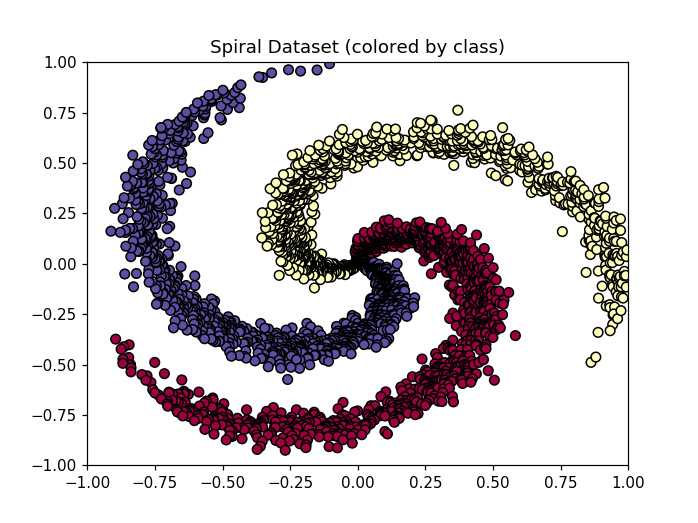

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5392f04358>)

In [3]:
toy_data.plot_spiraldata()

Our model is a simple 2-layer neural network

In [4]:
class Model:
    ''' A simple 2-layer neural network.
    
    Parameters
    ----------
    num_neurons : int, optional (default=100)
        The number of neurons in the first layer.
        
    num_classes : int, optional (default=3)
        The number of classes we're trying to categorize.
        
    num_input_dims : int, optional (default=2)
        The dimensionality of the input.
    '''
    def __init__(self, *, num_neurons=100, num_classes=3, num_input_dims=2):
        self.layer1 = dense(num_input_dims, num_neurons)
        self.layer2 = dense(num_neurons, num_classes)
        
    def __call__(self, x):
        ''' Perform a forward pass of the model.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor]
            The data to send through the model.
            
        Returns
        -------
        mygrad.Tensor
            The output logprobs of the model, obtained by taking the log_softmax.
        '''
        return log_softmax(self.layer2(relu(self.layer1(x))))
    
    @property
    def parameters(self):
        return self.layer1.parameters + self.layer2.parameters

In [5]:
model = Model(num_neurons=100, num_classes=3, num_input_dims=2)

This defines the optimizer we'll use: stochastic gradient descent. The optimizer needs the model parameters, so we'll pass those in as a tuple of parameters.

In [6]:
optim = SGD(model.parameters, learning_rate=0.01, momentum=0.99)

For visualizing our loss and accuracy, we'll use the LivePlot utility

<IPython.core.display.Javascript object>


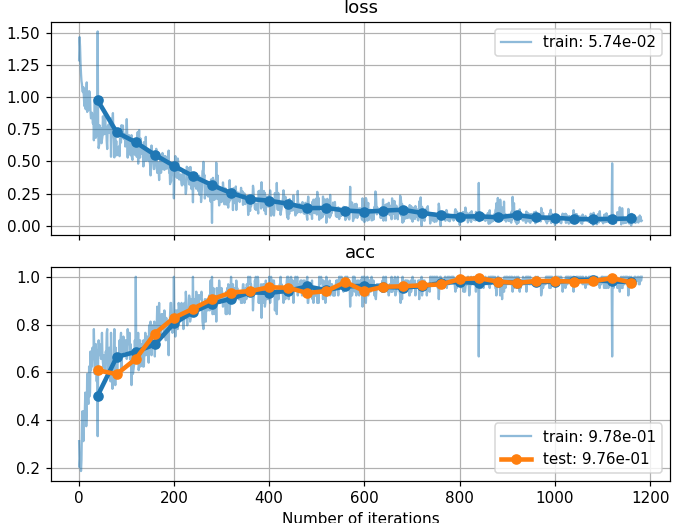

In [7]:
plotter, fix, ax = create_plot({'loss':None, 'acc':None}, 0.1)

We need to define a training and evaluation function for our model

In [8]:
def train_epoch(batch_size=64):
    ''' Train the model for one epoch. '''
    idxs = np.arange(len(train_data)) # randomize our batches
    np.random.shuffle(idxs)
    for batch in range(0, len(train_data), batch_size):
        batch_data = train_data[idxs[batch:batch+batch_size]]
        batch_labels = train_labels[idxs[batch:batch+batch_size]]
        
        outs = model(batch_data)                           # get the model output
        loss = negative_log_likelihood(outs, batch_labels) # compute the loss
        loss.backward()                                    # backpropagate
        optim.step()                                       # optimize the model
        loss.null_gradients()                              # clear the gradient
        
        # keep track of training statistics
        correct = (outs.data.argmax(axis=1) == batch_labels).sum()
        plotter.set_train_batch({'loss': loss.data, 'acc': correct / len(outs)}, len(outs))
    plotter.plot_train_epoch()

In [9]:
def eval_epoch(batch_size=64):
    ''' Evaluate the model on the test set. '''
    num_correct, num_total = 0, 0
    for batch in range(0, len(test_data), batch_size):
        batch_data = test_data[batch:batch+batch_size]
        batch_labels = test_labels[batch:batch+batch_size]
        
        outs = model(batch_data)
        outs.null_gradients()    # TODO David rewrite stuff so we don't have to do this
        
        correct = (outs.data.argmax(axis=1) == batch_labels).sum()
        samples = len(outs)
        num_correct += correct
        num_total += samples
        
        plotter.set_test_batch({'acc': correct / samples}, samples)
    plotter.plot_test_epoch()
        
    return num_correct, num_total

Train the model for 30 epochs

In [10]:
for i in range(30):
    train_epoch()
    eval_epoch()

Now we'll display our model's decision boundary.

<IPython.core.display.Javascript object>


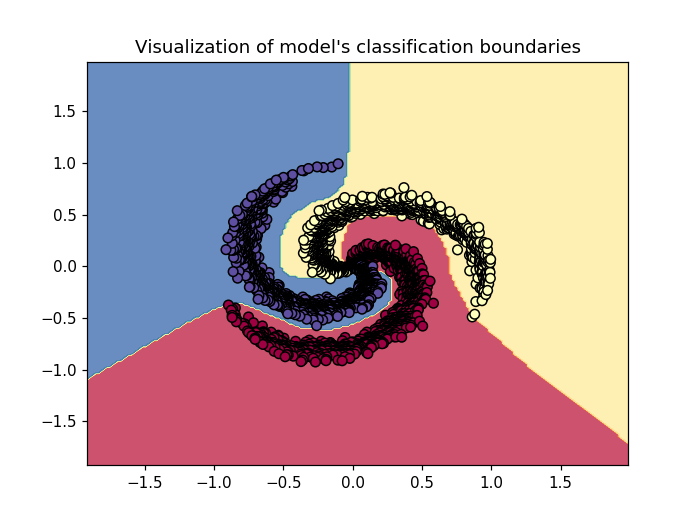

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f539117de80>)

In [11]:
def fwd(x):
    return model(x).data

toy_data.visualize_model(fwd)